# Preprocessing

In [956]:
import pandas as pd
import numpy as np
import re
import datetime
from os.path import exists
from geopy.geocoders import Nominatim
import folium
import json
import requests
import nltk
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.parsing.preprocessing import STOPWORDS
import pprint
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import PlaintextCorpusReader
from nltk import sent_tokenize,word_tokenize 
from itertools import chain
import matplotlib.pyplot as plt
from random import shuffle
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\adrie\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Now that the data has been scraped, we can take the data from all the cities we scraped and put them all together into one single dataframe.

In [957]:
places_raw = pd.read_excel('places.xlsx', header=None)
places = places_raw[0].values

index=0
cities_scraped = []
for city in places:
    if city not in cities_scraped:
        if exists('data_craigslist'+str(city)+'.csv'):
            cities_scraped.append(city)
            if index == 0:
                df = pd.read_csv('data_craigslist'+str(city)+'.csv').drop(columns=['Unnamed: 0'])
                index += 1
            else:
                df = pd.concat([df, pd.read_csv('data_craigslist'+str(city)+'.csv').drop(columns=['Unnamed: 0'])], axis=0, ignore_index=True)

In [958]:
# Gets rid of the rows where we don't have any features
new_index = []
for ind in df.index:
    try:
        if df.loc[ind].count() >= 7:
            new_index.append(ind)
    except:
        pass

df = df.loc[new_index].reset_index(drop=True)

In [959]:
df.columns

Index(['Price', 'Location', 'URL', 'Date', 'Title', 'num image', 'text',
       'condition', 'make / manufacturer', 'model name / number',
       'bicycle frame material', 'bicycle type', 'brake type',
       'electric assist', 'frame size', 'handlebar type', 'suspension',
       'wheel size', 'size / dimensions', 'serial number', 'part type',
       'paint color', 'year manufactured', 'engine hours (total)',
       'length overall (LOA)', 'propulsion type'],
      dtype='object')

In [960]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4624 entries, 0 to 4623
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Price                   4624 non-null   float64
 1   Location                4624 non-null   object 
 2   URL                     4624 non-null   object 
 3   Date                    4624 non-null   object 
 4   Title                   4624 non-null   object 
 5   num image               4624 non-null   int64  
 6   text                    4624 non-null   object 
 7   condition               2091 non-null   object 
 8   make / manufacturer     1828 non-null   object 
 9   model name / number     1283 non-null   object 
 10  bicycle frame material  1817 non-null   object 
 11  bicycle type            1817 non-null   object 
 12  brake type              679 non-null    object 
 13  electric assist         451 non-null    object 
 14  frame size              1717 non-null   

## Cleaning

Let's now go through every column and standardize the features. Because users fill these features by hand, they can type-in many different answers and we have to make sure they all stay consistent.

In [961]:
print(df['bicycle frame material'].unique())

[nan ' aluminum' ' alloy' ' other/unknown' ' steel' ' carbon fiber'
 ' titanium' ' composite' ' scandium']


In [962]:
def fix_bfm(x):
    if pd.isna(x) or x.strip() == 'other/unknown':
        return 'unknown'
    else:
        return x.strip()

df['bicycle frame material'] = df['bicycle frame material'].apply(fix_bfm)

In [963]:
print(df['bicycle frame material'].unique())

['unknown' 'aluminum' 'alloy' 'steel' 'carbon fiber' 'titanium'
 'composite' 'scandium']


In [964]:
df['bicycle type'].unique()

array([nan, ' mountain', ' other', ' kids', ' hybrid/comfort', ' cruiser',
       ' bmx', ' road', ' unicycle', ' folding', ' gravel',
       ' recumbent/trike', ' cyclocross', ' tandem', ' cargo/pedicab',
       ' track'], dtype=object)

In [965]:
def fix_bt(x):
    if pd.isna(x) or x.strip() == 'other':
        return 'unknown'
    else:
        return x.strip()

df['bicycle type'] = df['bicycle type'].apply(fix_bt)

In [966]:
df['bicycle type'].unique()

array(['unknown', 'mountain', 'kids', 'hybrid/comfort', 'cruiser', 'bmx',
       'road', 'unicycle', 'folding', 'gravel', 'recumbent/trike',
       'cyclocross', 'tandem', 'cargo/pedicab', 'track'], dtype=object)

In [967]:
df['frame size'].unique()

array([nan, ' Medium', ' Large', ' 26 inch', ' Fits most bikes!',
       ' 12” wheels', ' 18', ' 0', ' 8"', ' 24”', ' All', ' 26" and 24"',
       ' medium', ' 19.5', ' any', ' 56cm', ' 54 cm, medium', ' 60cm',
       ' All sizes', ' 16 inch', ' unknown', ' N/A', ' Unknown', ' None',
       ' 15 inch', ' 60 cm', ' 18 "', ' 19in', ' 26 in',
       ' 42x40x10 inches', ' 52 cm', ' Any size', ' 15"', ' 18.5”',
       ' n/a', ' Kids size', ' 50cm', " Women's Medium", ' 20" wheels',
       ' 26in.', ' Medium/Large', ' small', ' Small', " don't reall know",
       ' 54cm medium17.5', ' Adult', ' good size', ' MEDIUM TO LARGE',
       ' 27"', ' 20"', ' XXL', ' 65cm', ' 18.25 in (46.35 cm)', ' 20',
       ' child size', ' 49 to 63 cm', ' 26”', ' 16', ' 26"', " 26'",
       ' 16”, 12”', ' About 16 inches.', ' ?', ' 24"', ' .', ' 26',
       ' 17 inch, 25 inch, etc.', ' 17.5 in  54 in',
       ' Standard Cruiser Size', ' kids', ' see pictures',
       ' 19inches 49cm', ' Heavy-duty 57 cm.', ' 20”

In [968]:
def fix_fs(x):
    if pd.isna(x):
        return 'unknown'
    numbers = re.findall(r'\d+', x)
    if len(numbers) == 0:
        if 'medium' in x.lower():
            return 2
        elif 'large' in x.lower():
            return 3
        elif 'small' in x.lower():
            return 1
        else:
            return 'unknown'
    else:
        if '"' or "'" or 'inches' or 'inch' or 'in' in x.lower(): #it's in inches
            size = float(numbers[0]) # assume it's the first number
            if size < 16:
                return 1
            if size > 19:
                return 3
            else:
                return 2
        else: #cm
            size = float(numbers[0])
            if size < 53:
                return 1
            if size > 56:
                return 3
            else:
                return 2

df['frame size'] = df['frame size'].apply(fix_fs)

In [969]:
df['frame size'].unique()

array(['unknown', 2, 3, 1], dtype=object)

In [970]:
df['suspension'].unique()

array([nan, ' suspension fork (hardtail)', ' none (rigid)',
       ' other/unknown', ' frame and fork (full suspension)'],
      dtype=object)

In [971]:
def fix_s(x):
    if pd.isna(x):
        return 0
    if 'fork' in x.lower():
        return 1
    else:
        return 0

df['suspension'] = df['suspension'].apply(fix_s)

In [972]:
df['suspension'].unique()

array([0, 1], dtype=int64)

In [973]:
df['wheel size'].unique()

array([nan, ' 26 in', ' other/unknown', ' 12 in', ' 24 in', ' 20 in',
       ' 27 in', ' 700C', ' 25 in', ' 29 in', ' 14 in', ' 16 in',
       ' 10 in', ' 650B', ' 18 in', ' 27.5 in', ' 28 in', ' 26.5 in',
       ' 650C'], dtype=object)

In [974]:
def fix_ws(x):
    if pd.isna(x):
        return 'unknown'
    if '700' in x.strip():
        return 29
    if '650' in x.strip():
        return 26
    numbers = re.findall(r'\d+', x)
    if len(numbers)==0:
        return 'unknown'
    else:
        if int(numbers[0]) > 30:
            return 'unknown'
        else:
            return int(numbers[0])

df['wheel size'] = df['wheel size'].apply(fix_ws)

In [975]:
df['wheel size'].unique()

array(['unknown', 26, 12, 24, 20, 27, 29, 25, 14, 16, 10, 18, 28],
      dtype=object)

In [976]:
df['condition'].unique()

array([nan, ' excellent', ' new', ' good', ' salvage', ' like new',
       ' fair'], dtype=object)

In [977]:
def fix_c(x):
    if pd.isna(x):
        return 'unknown'
    x = str(x)
    if 'good' in x:
        return 3
    if 'fair' in x:
        return 2
    if 'salvage' in x or 'poor' in x:
        return 1
    if 'new' or 'excellent' in x:
        return 4
    
    return 'unknown'


df['condition'] = df['condition'].apply(fix_c)

In [978]:
df['condition'].unique()

array(['unknown', 4, 3, 1, 2], dtype=object)

In [979]:
df['electric assist'].unique()

array([nan, ' none', ' other', ' throttle', ' pedal assist'], dtype=object)

In [980]:
def fix_ea(x):
    if pd.isna(x):
        return 0
    x = str(x)
    if 'other' in x or 'none' in x:
        return 0
    return 1

df['electric assist'] = df['electric assist'].apply(fix_ea)

In [981]:
df['electric assist'].unique()

array([0, 1], dtype=int64)

In [982]:
df['make / manufacturer'].unique()

array([nan, ' Thule', ' BodyKore', ' Trek', ' Huffy', ' Diamondback',
       ' joystar', ' critical', ' huffy', ' SE Bikes', ' Saris',
       ' Royce Union, Huffy', ' Kent', ' Real tree', ' Cyberbike',
       ' all makes', ' NS Bikes', ' Fuji', ' Allen', ' Schwinn', ' Sun',
       ' Marin', ' Sole', ' Specialized', ' Life Fitness, Cybex, Hammer',
       ' Yakima', ' HUSQVARNA', ' Gatormade Trailers', ' roadmaster',
       ' Orbea', ' Bikemate', ' Suzuki', ' Viathon', ' Harley Davidson',
       ' Tony Hawk', ' Scott', ' Stamina', ' central bike', ' Litespeed',
       ' Jamis', ' mongoose', ' Rollfast', ' Giant', ' Windsor',
       ' Coleman', ' Rad Power Bikes', ' Maxxhaul', ' Dynacraft',
       ' grabber', ' Sears, JC Higgins', ' Salsa', ' Rad Power Bike',
       ' BMX', ' Hollywood', ' Triton', ' CUB CADET', ' BASS CAT',
       ' hotwheels', ' Charge Bikes', ' Free Spirit', ' All', ' Gibson',
       ' Bjorn', ' Lamar Trailers', ' Yamaha', ' sixthreezero',
       ' Rock Solid Cargo', '

In [983]:
def fix_mm(x):
    if pd.isna(x) or 'unknown' in x.lower():
        return 0
    return 1

df['make / manufacturer'] = df['make / manufacturer'].apply(fix_mm)

In [984]:
df['make / manufacturer'].unique()

array([0, 1], dtype=int64)

In [985]:
df['model name / number'].unique()

array([nan, ' 961XT Speedway', ' G703', ' 4300', ' Comfort tek', ' cub',
       ' So Cal Flyer', ' Grand Slam/4', ' See description', ' Four Bike',
       ' Unknown', ' Holy', ' Ace 24', ' Panther', ' Bobcat Trail 4',
       ' SB900', ' Ruby Pro', ' Dr. Tray plus one', ' ZERO TURN MOWER',
       ' Hotshot/ Gooseneck Trailer', ' Hardrock', ' power', ' Alma Cup',
       ' Hotrock', ' Gxsr', ' M.1', ' Sportster SuperLow XL883',
       ' Duosonic 8053-38', ' CR1 Team', ' Elite', ' ben hur',
       ' Sabre Titanium', ' Ariel', ' Satellite', ' FastRoad SLR',
       ' Rascal', ' Wellington', ' CT200AB', ' RadRunner2', ' grabber',
       ' 8002114', ' Campeon', ' Rad Rover', ' Duo glide', ' MONGOOSE',
       ' 914XT', ' HR8000', ' 179 TRX', ' LT 42', ' PANTERA', ' na',
       ' Radwagon Caboose', ' Breeze', ' All', ' 83" x 14\'', ' WR 250F',
       " Around the Block Men's Cruiser", " 7' x 16' x 7'",
       ' Super Cycle Shuttle', ' gamefisher', ' Series 50', ' General',
       ' COMPACT', ' L

In [986]:
def fix_mn(x):
    if pd.isna(x) or 'unknown' in x.lower():
        return 0
    return 1

df['model name / number'] = df['model name / number'].apply(fix_mn)

In [987]:
df['model name / number'].unique()

array([0, 1], dtype=int64)

In [988]:
df['brake type'].unique()

array([nan, ' cantilever', ' disc (mechanical)', ' caliper', ' none',
       ' other/unknown', ' coaster', ' disc (hydraulic)', ' gyro/bmx',
       ' u-brakes', ' v-brakes', ' drum', ' hydraulic rim brakes'],
      dtype=object)

In [989]:
def fix_bt(x):
    if pd.isna(x) or 'other/unknown' in x.lower() or 'none' in x.lower():
        return 'unknown'
    else:
        x = str(x)
        if 'hydraulic' in x:
            return 'hydraulic'
        elif 'mechanical' in x:
            return 'mechanical'
        else:
            return 'special'

df['brake type'] = df['brake type'].apply(fix_bt)

In [990]:
df['brake type'].unique()

array(['unknown', 'special', 'mechanical', 'hydraulic'], dtype=object)

In [991]:
df['handlebar type'].unique()

array([nan, ' flat', ' bmx', ' other/unknown', ' drop', ' cruiser',
       ' triathlon', ' riser', ' downhill', ' aero', ' bullhorn'],
      dtype=object)

In [992]:
def fix_ht(x):
    if pd.isna(x) or 'other/unknown' in x:
        return 'unknown'
    else:
        return 'special'

df['handlebar type'] = df['handlebar type'].apply(fix_ht)

In [993]:
df['handlebar type'].unique()

array(['unknown', 'special'], dtype=object)

In [994]:
df['part type'].unique()

array([nan, ' other', ' racks, fenders, bags', ' saddle',
       ' grips, bar ends, tape', ' tires', ' wheels and wheel parts',
       ' crankset, bottom bracket, guards', ' brakes', ' pedals',
       ' headset, stem, spacers', ' frame only'], dtype=object)

In [995]:
def fix_pt(x):
    if pd.isna(x) or 'other' in x.lower():
        return 0
    else:
        return 1

df['part type'] = df['part type'].apply(fix_pt)
# Let's get rid of the listings about parts
df = df.where(df['part type']==0).dropna(how='all').drop(columns=['part type'])

In [996]:
df['size / dimensions'].unique()

array([nan, ' 1 1/4” hitch', ' 26.38 x 12.2 x 13.98',
       ' \u200e42 x 40 x 10 inches', ' 750', ' 56x9.5x4.5',
       ' 4-bike capacity', ' 168" X 86" X 0"', ' 192" X 84" X 0"',
       ' 168" X 83" X 0"', ' 26”', ' 2011---2016', ' 51x 48x30',
       ' 36 Volt 42 Volt 48 Volt', ' S, L, M, XL, XXL', ' See above',
       ' 5\'×17" UNFOLDED', ' 31.5 x 21 x 25.5 in (Interior)',
       ' 125cc 250cc 500cc', ' 8.5 x 28', " Women's size medium", ' 1111',
       ' Large', ' 22', ' na', ' 196cc', ' 9 x 22', ' 7.48 mm',
       ' 2500 sq feet', ' 6 feet', ' 12x5', ' 42', ' 59x32x42in',
       ' 7.5 feet tall approx', ' 5x1x3,12', " Men's Large",
       ' Fully Inspected', ' 41" x 20"', ' X-Large', ' 62"wide',
       ' 7X14X3 16K GN DUMP TRAILER', ' 25 LBS', ' 40’x 7’8”x 79”tall',
       ' 32" x 68" x 74"', ' 20”', ' 3x4', ' 600', ' Holds 4 Bikes', ' ?',
       ' 130/90-16', ' 16 x 5.00', ' 240" X 82" X 0"', ' 144" X 76" X 0"',
       ' 240" X 102" X 0"', ' 432" X 102" X 0"', ' 240" X 83" X 0"',

In [997]:
def fix_sd(x):
    if pd.isna(x):
        return 0
    else:
        return 1

df['size / dimensions'] = df['size / dimensions'].apply(fix_sd)

In [998]:
df['size / dimensions'].unique()

array([0, 1], dtype=int64)

In [999]:
df['paint color'].unique()

array([nan, ' black', ' grey', ' custom', ' white', ' silver', ' red'],
      dtype=object)

In [1000]:
def fix_pc(x):
    if pd.isna(x):
        return 0
    else:
        return 1

df['paint color'] = df['paint color'].apply(fix_pc)

In [1001]:
df['paint color'].unique()

array([0, 1], dtype=int64)

In [1002]:
df['serial number'].unique()

array([nan, ' Unknown', ' F1068892', ' N/A', ' EN14872XINGING',
       ' TC19 222501', ' na', ' NSN not needed', ' Model GS32401', ' 000',
       ' 20A16575', ' M5060820', ' RU1F20V0502', ' yes', ' GS62660',
       ' un', ' EB720DO', ' S  / N', ' on request', ' none',
       ' AITPZ29SD6L1G1', ' SNHU07J15066', ' #185', ' F7U42856',
       ' LF201110072', ' ?', ' 01V120067', ' E6EE07509', ' Assorted',
       ' WSBC025068284R', ' 170720', ' 26’', ' M50', ' UUK19C01204',
       ' EZ-201304 468', ' 408 406 7864 cell', ' Var', ' Nome', ' 23-918',
       ' See Photos', ' unknown', ' EG010897', ' 00012345', ' .',
       ' various', ' Ninja 2021', ' Freestyle', ' ??', ' NA',
       ' WT0406C5218', ' WTU336CT0109R1207', ' N/a', ' 1234567890',
       ' CU5C21B3934', ' see photos'], dtype=object)

In [1003]:
def fix_sn(x):
    if pd.isna(x) or 'unknown' in x.lower() or 'na' in x.lower() or 'none' in x.lower():
        return 0
    else:
        return 1

df['serial number'] = df['serial number'].apply(fix_sn)

In [1004]:
df['serial number'].unique()

array([0, 1], dtype=int64)

In [1005]:
df['year manufactured'].unique()

array([  nan, 2022., 2020., 2010., 1975., 2018., 2015., 1979., 2005.,
       2021., 2013., 1987., 2001., 2019., 2012., 2017., 2006.])

In [1006]:
def fix_ym(x):
    if pd.isna(x):
        return 0
    else:
        return 1

df['year manufactured']=df['year manufactured'].apply(fix_ym)

In [1007]:
df['year manufactured'].unique()

array([0, 1], dtype=int64)

In [1008]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4559 entries, 0 to 4623
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Price                   4559 non-null   float64
 1   Location                4559 non-null   object 
 2   URL                     4559 non-null   object 
 3   Date                    4559 non-null   object 
 4   Title                   4559 non-null   object 
 5   num image               4559 non-null   float64
 6   text                    4559 non-null   object 
 7   condition               4559 non-null   object 
 8   make / manufacturer     4559 non-null   float64
 9   model name / number     4559 non-null   float64
 10  bicycle frame material  4559 non-null   object 
 11  bicycle type            4559 non-null   object 
 12  brake type              4559 non-null   object 
 13  electric assist         4559 non-null   float64
 14  frame size              4559 non-null   

In [1009]:
df.columns

Index(['Price', 'Location', 'URL', 'Date', 'Title', 'num image', 'text',
       'condition', 'make / manufacturer', 'model name / number',
       'bicycle frame material', 'bicycle type', 'brake type',
       'electric assist', 'frame size', 'handlebar type', 'suspension',
       'wheel size', 'size / dimensions', 'serial number', 'paint color',
       'year manufactured', 'engine hours (total)', 'length overall (LOA)',
       'propulsion type'],
      dtype='object')

In [1010]:
# These 3 columns have less than 0.1% of data available so we'll drop them
df = df.drop(columns=['length overall (LOA)', 'propulsion type', 'engine hours (total)'])

In [1011]:
df.columns = [column.replace('/', '').lower().strip().replace(' ', '') for column in df.columns]

In [1012]:
df.columns

Index(['price', 'location', 'url', 'date', 'title', 'numimage', 'text',
       'condition', 'makemanufacturer', 'modelnamenumber',
       'bicycleframematerial', 'bicycletype', 'braketype', 'electricassist',
       'framesize', 'handlebartype', 'suspension', 'wheelsize',
       'sizedimensions', 'serialnumber', 'paintcolor', 'yearmanufactured'],
      dtype='object')

Let's add the number of days since the listing was posted on the website as a feature.

In [1013]:
df['days'] = [(datetime.datetime.today()-datetime.datetime.strptime(date_, "%Y-%m-%d %H:%M")).days for date_ in df['date']]

# Missing values analysis

How many of each features are we missing, and can we find these values within the text (body of the listing)?

In [1014]:
important_attributes = ['price', 'condition', 'numimage', 'bicycleframematerial', 'bicycletype', 'braketype', 'framesize', 'handlebartype','wheelsize']

for column in important_attributes:
    df_values = pd.DataFrame(df.groupby([column]).size())
    display(df_values)

,0
price,
1.0,205
2.0,1
4.0,1
5.0,20
7.0,1
...,...
445522.0,1
595000.0,1
999992.0,1


,0
condition,
1,16
2,77
3,450
4,1492
unknown,2524


,0
numimage,
0.0,836
2.0,457
3.0,418
4.0,432
5.0,325
6.0,320
7.0,282
8.0,187
9.0,144


,0
bicycleframematerial,
alloy,177
aluminum,603
carbon fiber,98
composite,13
scandium,1
steel,488
titanium,9
unknown,3170


,0
bicycletype,
bmx,186
cargo/pedicab,6
cruiser,174
cyclocross,6
folding,39
gravel,26
hybrid/comfort,137
kids,216
mountain,433


,0
braketype,
hydraulic,187
mechanical,98
special,305
unknown,3969


,0
framesize,
1,208
2,455
3,608
unknown,3288


,0
handlebartype,
special,394
unknown,4165


,0
wheelsize,
10,25
12,53
14,27
16,78
18,36
20,212
24,103
25,14
26,431


In [1015]:
def loss_analysis(df):
    unknown_dic = dict()
    n=len(df)
    for column in important_attributes:
        df_values = pd.DataFrame(df.groupby([column]).size())
        if column == 'price':
            unknown = len(df[(df['price']<10) | (df['price']>300)])
            unknown_dic[column]=[unknown,round(unknown/n*100,1)]
        try:
            unknown = int(df_values.loc['unknown'])
        except:
            pass
        else:
            unknown_dic[column]=[unknown,round(unknown/n*100,1)]
    df_unknown = pd.DataFrame(data=unknown_dic,index=['Unknowns','% of Unknowns']).transpose()
    return df_unknown

In [1016]:
loss_analysis(df)

,Unknowns,% of Unknowns
price,2526.0,55.4
condition,2524.0,55.4
bicycleframematerial,3170.0,69.5
bicycletype,3058.0,67.1
braketype,3969.0,87.1
framesize,3288.0,72.1
handlebartype,4165.0,91.4
wheelsize,3153.0,69.2


## Let's look into the text

In [1017]:
def retrieve_condition_from_txt(text):
    sentences = re.compile(r'([A-Z][^\.!?]*[\.!?])', re.M).findall(text)
    for sentence in sentences:
        if 'condition' in sentence:
            return sentence

def fix_condition_from_txt(text,condition):
    if condition != 'unknown':
        return condition
    else:
        sentence = retrieve_condition_from_txt(text)
        if sentence is None:
            return 'unknown'
        else:
            sentence = sentence.lower()
            if 'very good' in sentence or 'excellent' in sentence or 'new' in sentence or 'very nice' in sentence:
                return str(4)
            if 'good used condition' in sentence or 'good' in sentence or 'very pretty' in sentence or 'great' in sentence:
                return str(3)
            if 'nice' in sentence or 'fair' in sentence:
                return str(2)
            if 'poor' in sentence or 'salvage' in sentence:
                return str(1)
            else:
                return 'unknown'

before = loss_analysis(df).loc['condition','Unknowns']
df['condition'] = df.apply(lambda x: fix_condition_from_txt(x['text'],x['condition']), axis=1)
after = loss_analysis(df).loc['condition','Unknowns']
print("+ "+ str(int(before-after)) + " data for 'condition' after using fix_condition_from_txt.")


+ 306 data for 'condition' after using fix_condition_from_txt.


In [1018]:
def fix_material_from_txt(text, material):
    if material != 'unknown':
        return material
    else:
        if 'aluminum' in text:
            return 'aluminum'
        if 'alloy' in text:
            return 'alloy'
        if 'steel' in text:
            return 'steel'
        if 'carbon' in text:
            return 'carbon fiber'
        if 'titanium' in text:
            return 'titanium'
        if 'composite' in text:
            return 'composite'
        if 'scandium' in text:
            return 'scandium'
        else:
            return 'unknown'


before = loss_analysis(df).loc['bicycleframematerial','Unknowns']
df['bicycleframematerial'] = df.apply(lambda x: fix_material_from_txt(x['text'],x['bicycleframematerial']), axis=1)
after = loss_analysis(df).loc['bicycleframematerial','Unknowns']
print("+ "+ str(int(before-after)) + " data for 'bicycleframematerial' after using fix_material_from_txt.")

+ 404 data for 'bicycleframematerial' after using fix_material_from_txt.


In [1019]:
def fix_bicycletype_from_txt(text,bicycletype):
    if bicycletype != 'unknown':
        return bicycletype
    else:
        if 'mountain' in text:
            return 'mountain'
        if 'kids' in text:
            return 'kids'
        if 'hybrid' in text:
            return 'hybrid/comfort'
        if 'comfort' in text:
            return 'hybrid/comfort'
        if 'cruiser' in text:
            return 'cruiser'
        if 'bmx' in text:
            return 'bmx'
        if 'road' in text:
            return 'road'
        if 'unicycle' in text:
            return 'unicycle'
        if 'folding' in text:
            return 'folding'
        if 'gravel' in text:
            return 'gravel'
        if 'recumbent' in text:
            return 'recumbent/trike'
        if 'cyclocross' in text:
            return 'cyclocross'
        if 'tandem' in text:
            return 'tandem'
        if 'track' in text:
            return 'track'
        if 'cargo' in text:
            return 'cargo/pedicab'
        if 'pedicab' in text:
            return 'cargo/pedicab'
        else:
            return 'unknown'

before = loss_analysis(df).loc['bicycletype','Unknowns']
df['bicycletype'] = df.apply(lambda x: fix_bicycletype_from_txt(x['text'],x['bicycletype']), axis=1)
after = loss_analysis(df).loc['bicycletype','Unknowns']
print("+ "+ str(int(before-after)) + " data for 'bicycletype' after using fix_bicycletype_from_txt.")

+ 1052 data for 'bicycletype' after using fix_bicycletype_from_txt.


In [1020]:
def fix_braketype_from_txt(text,braketype):
    if braketype != 'unknown':
        return braketype
    else:
        if 'mechanical' in text:
            return 'mechanical'
        if 'hydraulic' in text:
            return 'hydraulic'
        else:
            return 'unknown'

before = loss_analysis(df).loc['braketype','Unknowns']
df['braketype'] = df.apply(lambda x: fix_braketype_from_txt(x['text'],x['braketype']), axis=1)
after = loss_analysis(df).loc['braketype','Unknowns']
print("+ "+ str(int(before-after)) + " data for 'braketype' after using fix_braketype_from_txt.")

+ 113 data for 'braketype' after using fix_braketype_from_txt.


In [1021]:
loss_analysis(df)

,Unknowns,% of Unknowns
price,2526.0,55.4
condition,2218.0,48.7
bicycleframematerial,2766.0,60.7
bicycletype,2006.0,44.0
braketype,3856.0,84.6
framesize,3288.0,72.1
handlebartype,4165.0,91.4
wheelsize,3153.0,69.2


# Price preprocessing

It happens pretty often that people set unrealistic prices, of $1 for example. Sometimes, people don't sell bikes too, they sell motorcycles, which are much more extensive. The goal of this part is to get rid of these listings, and if possible, to retrieve the real price from the text.

In [1022]:
df.price.describe()

count    4.559000e+03
mean     2.141205e+04
std      9.862088e+05
min      1.000000e+00
25%      7.500000e+01
50%      3.250000e+02
75%      2.750000e+03
max      6.543290e+07
Name: price, dtype: float64

The standard deviation is extremely high, let's look carefully into the listings with a price greater than $3000 or smaller than $10.

In [1023]:
df_filter = df[(df['price']>3000) | (df['price']<10)]
print(f'The number of incoherent announces regarding their price is: ',len(df_filter))

The number of incoherent announces regarding their price is:  1310


For example, you can see below the discrepancy between the listed price and the one we can find in the text:

For one listing we have:

- Price: $ 1.0
- Description:  SCHWINN CLASSIC BIKES, SELLING AS A PAIR. ONLY $100 FOR BOTH!

In [1024]:
index_list = df_filter.index
index_list_final = list()
new_price_list = list()

for i in df.index:
  if i in df_filter.index:
    new_price_int = list()
    try:
      new_price = re.findall('\$(\x20?\d+(?:[,]\d{0,3})?)', df_filter['text'][i])
      for j in new_price:
        new_price_int.append(int(j.replace(',','')))
      if new_price_int == []:
        new_price = float('Nan')
        new_price_list.append(new_price)
        index_list_final.append(i)
      else:
        new_price_list.append(int(sum(new_price_int)/len(new_price_int)))
        index_list_final.append(i)
    except:
      #If there is no match, we replace the price value by NaN to eliminate them easily from our database
      new_price_list.append(float('Nan'))
      index_list_final.append(i)
  else:
    new_price_list.append(df['price'][i])
    index_list_final.append(i)

df_new_price = pd.DataFrame({'price' : new_price_list, 'Index':index_list_final})
df_new_price.set_index('Index', inplace = True)
df_new_price.head()

,price
Index,
0,1000.0
1,NaN
2,2995.0
3,30.0
4,112.0


Let's add back the new prices we found:

In [1025]:
df['price'] = df_new_price['price']

In [1026]:
df.price.describe()

count      3899.000000
mean       2029.679918
std        9098.659661
min           0.000000
25%          75.000000
50%         250.000000
75%        1395.000000
max      317422.000000
Name: price, dtype: float64

In [1027]:
df = df[(df['price']<=3000) & (df['price']>=10)]

In [1028]:
df.price.describe()

count    3504.000000
mean      593.587614
std       768.312628
min        10.000000
25%        68.000000
50%       200.000000
75%       895.000000
max      3000.000000
Name: price, dtype: float64

We can see above that the standard deviation is now much smaller, and that the values seem more realistic for bikes.

# Let us get rid of the non-bikes listings by finding topics within text

In [1029]:
#We will use the description and the title of the annouce to get the topic

df_info = df[['text','title']]

bike_desc_list = list()
for i in df_info.index:
    bike_desc_list.append(df_info['title'][i]+df_info['text'][i])

for i in range(len(bike_desc_list)):
    desc = bike_desc_list[i]
    sents = sent_tokenize(desc)
    for j in range(len(sents)):
        sent = sents[j]
        sent = sent.strip().replace('\n','')
        sents[j] = sent
    bike_desc_list[i] = '. '.join(sents)

texts = [[word for word in desc.lower().split()
        if word not in STOPWORDS and word.isalpha() and not word.lower() == 'slate'] #We only keep alpha values
        for desc in bike_desc_list]

dictionary = corpora.Dictionary(texts) #(word_id,word) pairs
corpus = [dictionary.doc2bow(text) for text in texts] #(word_id,freq) pairs by sentence

In [1030]:
#Set parameters
num_topics = 3 #The number of topics that should be generated
passes = 10

lda = LdaModel(corpus,
              id2word=dictionary,
              num_topics=num_topics,
              passes=passes)

pp = pprint.PrettyPrinter(indent=4)
pp.pprint(lda.print_topics(num_words=8))

lda.show_topic(2)

[   (   0,
        '0.030*"bike" + 0.023*"bikes" + 0.013*"new" + 0.007*"rack" + '
        '0.006*"will" + 0.006*"go" + 0.006*"hitch" + 0.006*"one"'),
    (   1,
        '0.109*"trailers" + 0.064*"motorcycle" + 0.044*"camping" + 0.037*"car" '
        '+ 0.027*"trailer" + 0.027*"dolly" + 0.025*"sale" + 0.025*"used"'),
    (   2,
        '0.010*"bike" + 0.009*"inch" + 0.007*"equipment" + 0.006*"front" + '
        '0.006*"rear" + 0.006*"road" + 0.005*"frame" + 0.005*"brakes"')]


[('bike', 0.009582784),
 ('inch', 0.009232766),
 ('equipment', 0.007316863),
 ('front', 0.005666216),
 ('rear', 0.005529693),
 ('road', 0.0055156443),
 ('frame', 0.0053132614),
 ('brakes', 0.005156931),
 ('ready', 0.004987876),
 ('bikes', 0.0047963015)]

In [1031]:
lda_corpus = lda[corpus]

# Find the threshold, let's set the threshold to be 1/#clusters,
# To prove that the threshold is sane, we average the sum of all probabilities:
scores = list(chain(*[[score for topic_id,score in topic] \
                      for topic in [doc for doc in lda_corpus]]))
threshold = sum(scores)/len(scores)
print(threshold)
index_cluster1=[]
index_cluster2=[]
index_cluster3=[]
counter = -1
for i,j in zip(lda_corpus,bike_desc_list):
    counter+=1
    for size in range(len(i)):
        if i[size][1] > threshold:
            if i[size][0] == 0:
                index_cluster1.append(counter)
            elif i[size][0] == 1:
                index_cluster2.append(counter)
            elif i[size][0] == 2:
                index_cluster3.append(counter)

0.4124838398744651


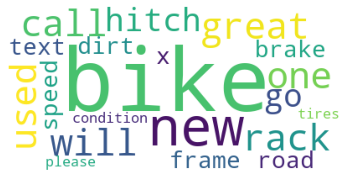

In [1032]:
#We create word clouds to know which cluster corresponds to which topics

def draw_wordcloud(lda,topicnum,min_size=0,STOPWORDS=[]):
    word_list=[]
    prob_total = 0
    for word,prob in lda.show_topic(topicnum,topn=50):
        prob_total +=prob
    for word,prob in lda.show_topic(topicnum,topn=50):
        if word in STOPWORDS or  len(word) < min_size:
            continue
        freq = int(prob/prob_total*100)
        alist=[word]
        word_list.extend(alist*freq)
        
    %matplotlib inline
    shuffle(word_list)
    text = ' '.join(word_list)
    wordcloud = WordCloud(stopwords=STOPWORDS,background_color='white',max_words=20).generate(text)

    plt.axis('off')
    plt.imshow(wordcloud)

    return word_list

word_list_1 = draw_wordcloud(lda,0)

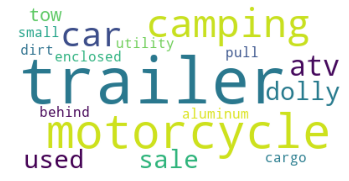

In [1033]:
word_list_2 = draw_wordcloud(lda,1)

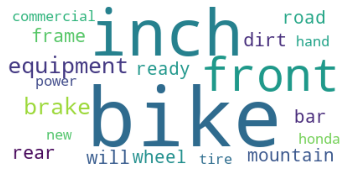

In [1034]:
word_list_3 = draw_wordcloud(lda,2)

In [1035]:
def count_bike(list_words):
    count=0
    for word in list_words:
        if word == 'bike' or word == 'bikes':
            count+=1
    return count

In [1036]:
word_lists = [word_list_1, word_list_2, word_list_3]

index_not_bikes = []
for i, words in enumerate(word_lists):
    if count_bike(words) < 3:
        if i == 0:
            index_not_bikes += index_cluster1
        elif i == 1:
            index_not_bikes += index_cluster2
        elif i == 2:
            index_not_bikes += index_cluster3

print(f'We are getting rid of {len(index_not_bikes)} rows.')
print(f'Cluster 1 has {len(index_cluster1)} rows.')
print(f'Cluster 1 has {len(index_cluster2)} rows.')
print(f'Cluster 1 has {len(index_cluster3)} rows.')

We are getting rid of 227 rows.
Cluster 1 has 2740 rows.
Cluster 1 has 227 rows.
Cluster 1 has 769 rows.


In [1037]:
# We delete the annouces which do not correspond to bike annouces for sure
df = df.reset_index(drop=True)

for i in index_not_bikes:
    df.drop(index=i, inplace = True)
df.reset_index(inplace = True)
df.drop(columns = 'index', inplace= True)

In [1038]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3277 entries, 0 to 3276
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   price                 3277 non-null   float64
 1   location              3277 non-null   object 
 2   url                   3277 non-null   object 
 3   date                  3277 non-null   object 
 4   title                 3277 non-null   object 
 5   numimage              3277 non-null   float64
 6   text                  3277 non-null   object 
 7   condition             3277 non-null   object 
 8   makemanufacturer      3277 non-null   float64
 9   modelnamenumber       3277 non-null   float64
 10  bicycleframematerial  3277 non-null   object 
 11  bicycletype           3277 non-null   object 
 12  braketype             3277 non-null   object 
 13  electricassist        3277 non-null   float64
 14  framesize             3277 non-null   object 
 15  handlebartype        

# Analysis and visualization

Let's visualize the average price per state.

In [1039]:
def preprocess_cities(cities):
    for i, city in enumerate(cities):
        if city == 'newyork':
            cities[i] = 'new york'
        elif city == 'newjersey':
            cities[i] = 'new jersey'
        elif city == 'lasvegas':
            cities[i] = 'las vegas'
        elif city == 'longisland':
            cities[i] = 'long island'
        elif city == 'losangeles':
            cities[i] = 'los angeles'
        elif city == 'saltlakecity':
            cities[i] = 'salt lake city'
        elif city == 'sfbay':
            cities[i] = 'san francisco'
    return cities

def preprocess_back_cities(cities):
    for i, city in enumerate(cities):
        if city == 'new york':
            cities[i] = 'newyork'
        elif city == 'new jersey':
            cities[i] = 'newjersey'
        elif city == 'las vegas':
            cities[i] = 'lasvegas'
        elif city == 'long island':
            cities[i] = 'longisland'
        elif city == 'los angeles':
            cities[i] = 'losangeles'
        elif city == 'salt lake city':
            cities[i] = 'saltlakecity'
        elif city == 'san francisco':
            cities[i] = 'sfbay'
    return cities

all_cities = preprocess_cities(df['location'].unique())

In [1040]:
states= ['Alabama', 'Alaska', 'Arizona', 'Arkansas','California', 'Colorado', 'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois'
,'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri'
,'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma'
,'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']

codes = ['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE'
,'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY']

state_codes = {}
for i, state in enumerate(states):
    state_codes[state] = codes[i]

In [1041]:
def find_states(all_cities):
    """Takes a list of cities and returns a dictionary of the cities and their corresponding state."""
    geolocator = Nominatim(user_agent="location script")
    
    dict_states = {}
    
    for city in all_cities:

        location = str(geolocator.geocode(city))
        for state in states:
            if state.lower() in location.lower():
                dict_states[city] = state_codes[state]
        
    return dict_states #finally retruns the dict 

city_states = find_states(all_cities)

states_cities = {}
for key in city_states:
    if city_states[key] not in states_cities:
        states_cities[city_states[key]] = [key]
    else:
        states_cities[city_states[key]].append(key)

In [1042]:
def find_mean_price_per_state(state_cities_dict):

    price_per_state = {}

    for state in state_cities_dict:

        price_per_state[state] = []

        list_of_cities_not_ready = state_cities_dict[state]
        list_of_cities = preprocess_back_cities(list_of_cities_not_ready)

        for city in list_of_cities:
            price_per_state[state].append(df.where(df['location']==city).dropna()['price'].mean())

        price_per_state[state] = np.mean(price_per_state[state])
    
    return price_per_state

mean_price_data = pd.DataFrame.from_dict(find_mean_price_per_state(states_cities), 'index', columns=['mean price']).reset_index().rename(columns={'index':'state'})
mean_price_data.head()

,state,mean price
0,AL,494.416475
1,IN,454.789474
2,AK,501.662631
3,AZ,666.885548
4,NM,649.218750


In [1043]:
us_states_url_indata = {}
data_url = ("https://raw.githubusercontent.com/python-visualization/folium/master/examples/data")
us_states_url = f"{data_url}/us-states.json"
t = requests.get(us_states_url).content
geodict = json.loads(t)
us_states_url_indata['type'] = geodict['type']
us_states_url_indata['features'] = []
for state_dic in geodict['features']:
    if state_dic['id'] in mean_price_data['state'].values:
        us_states_url_indata['features'].append(state_dic)

In [1044]:
m = folium.Map(location=[48, -102], zoom_start=3)

folium.Choropleth(
    geo_data=us_states_url_indata,
    name='choropleth',
    data=mean_price_data,
    columns=['state', 'mean price'],
    key_on='feature.id',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Mean price'
).add_to(m)

m

In [1045]:
df.to_csv('preprocessed_data_craigslist.csv')